In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc

from discodj import DiscoDJ
import jax
import jax.numpy as jnp

### Generating parameters via Latin Hypercube

In [2]:
cosmo_params_names = ['omega_b', 'omega_cdm', 'h', 'n_s', 'sigma8', 'z']

ob_h2 =     np.array([0.01865, 0.02625])
omc_h2 =    np.array([0.05,    0.255])
h =         np.array([0.64,    0.82])
ns =        np.array([0.84,    1.1])
sigma8 =      np.array([0.6,    1])  # set up pretty arbitrarily for now
# lnAs =      np.array([1.61,    3.91])
# cmin =      np.array([2.,      4.])
# eta0 =      np.array([0.5,     1.])
z =         np.array([0,       5.])

cosmo_params_bounds = np.stack([ob_h2, omc_h2, h, ns, sigma8, z])
print(cosmo_params_bounds.shape)

(6, 2)


In [3]:
def generate_lhs_samples(n_samples, bounds_array, seed=None):
    """
    Generate reproducible Latin Hypercube Samples with bounds as a NumPy array.

    Parameters:
    - n_samples (int): Number of samples to generate.
    - bounds_array (np.ndarray): Array of shape (n_dimensions, 2),
                                 each row is [min, max] for one parameter.
    - seed (int or None): Seed for reproducibility.

    Returns:
    - np.ndarray: (n_samples x n_dimensions) array of samples.
    """
    bounds_array = np.asarray(bounds_array)
    if bounds_array.ndim != 2 or bounds_array.shape[1] != 2:
        raise ValueError("bounds_array must be of shape (n_dimensions, 2)")

    n_dimensions = bounds_array.shape[0]

    # Latin Hypercube sampler with seed
    sampler = qmc.LatinHypercube(d=n_dimensions, seed=seed)
    unit_samples = sampler.random(n=n_samples)

    # Scale samples to custom bounds
    l_bounds = bounds_array[:, 0]
    u_bounds = bounds_array[:, 1]
    scaled_samples = qmc.scale(unit_samples, l_bounds, u_bounds)

    return scaled_samples

In [4]:
n_samples = 10_000
cosmo_params_samples = generate_lhs_samples(n_samples, cosmo_params_bounds, seed=42)
print(cosmo_params_samples.shape)

(10000, 6)


In [5]:
# training_data = {}
# training_data['cosmo_params_samples'] = cosmo_params_samples
# training_data['cosmo_params_names'] = cosmo_params_names
# np.savez('./training_data/training_data_EH.npz', **training_data)

### Generating EH power spectra

In [45]:
# Loading pre-generated training data

training_data = np.load('./training_data/training_data_EH.npz')
training_data = {key: training_data[key] for key in training_data.files}
print(training_data.keys())

cosmo_params_names = training_data['cosmo_params_names']
k_modes = training_data['modes']
cosmo_params_samples = training_data['cosmo_params_samples']
power_spectra = training_data['power_spectra']
diff_power_spectra = training_data['diff_power_spectra']
hess_power_spectra = training_data['hess_power_spectra']

print('cosmo_params_names:', cosmo_params_names)
print('cosmo_params_samples.shape =', cosmo_params_samples.shape)
print('k_modes.shape =', k_modes.shape)
print('power_spectra.shape = ', power_spectra.shape)
print('diff_power_spectra.shape =', diff_power_spectra.shape)
print('hess_power_spectra.shape =', hess_power_spectra.shape)


dict_keys(['cosmo_params_samples', 'power_spectra', 'modes', 'cosmo_params_names', 'diff_power_spectra', 'hess_power_spectra'])
cosmo_params_names: ['omega_b' 'omega_cdm' 'h' 'n_s' 'sigma8' 'z']
cosmo_params_samples.shape = (10000, 6)
k_modes.shape = (420,)
power_spectra.shape =  (10000, 420)
diff_power_spectra.shape = (10000, 420, 6)
hess_power_spectra.shape = (10000, 420, 6, 6)


In [10]:
@jax.jit
def _compute_pk_impl(k, cosmo_params):
    dim, res, boxsize = 3, 512, 500
    ob_h2, omc_h2, h, ns, s8, z = cosmo_params

    cosmo = {'h':        h ,
            'Omega_b':  ob_h2 / h**2,
            'Omega_c':  omc_h2 / h**2,
            'n_s':      ns, 
            'sigma8':   s8}

    dj = DiscoDJ(dim=dim, res=res, boxsize=boxsize, device='gpu', cosmo=cosmo, requires_jacfwd=True)
    dj = dj.with_timetables()
    dj = dj.with_linear_ps()
    Pk = dj.evaluate_linear_ps(a=1/(1+z), k=k)
    return Pk

compute_pk = jax.vmap(_compute_pk_impl, in_axes=(0, None))

_compute_pk_batched = jax.vmap(compute_pk, in_axes=(None, 0))

def compute_pk_batched(cosmo_params_batch, k=np.logspace(-4, 2, 420)):
    Pks = _compute_pk_batched(k, cosmo_params_batch)
    return Pks, k

In [12]:
Pk_in_Mpc_h = compute_pk(np.logspace(-4, 2, 420), cosmo_params_samples[0])
Pk_in_Mpc_h.shape

(420,)

In [18]:
power_spectra, k_modes = compute_pk_batched(cosmo_params_samples)
power_spectra.shape

(10000, 420)

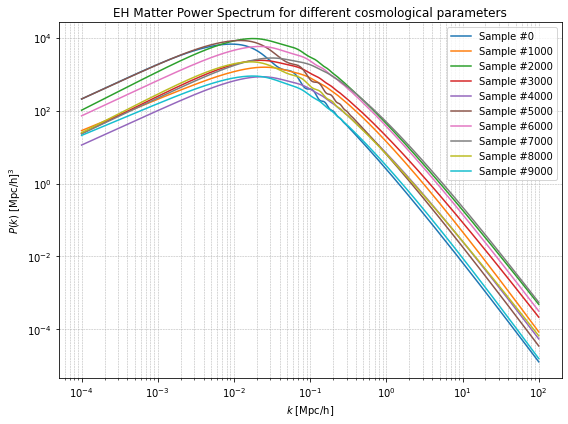

In [13]:
plt.figure(figsize=(8, 6))
# power_spectra = training_data['power_spectra']
# k_modes = training_data['k_modes']

for i in range(0, len(power_spectra), 1000):
    Pk = power_spectra[i]
    plt.loglog(k_modes, Pk, linewidth=1.5, label=f'Sample #{i}',)

plt.xlabel(r'$k$ [Mpc/h]')
plt.ylabel(r'$P(k)$ [Mpc/h]$^3$')
plt.title('EH Matter Power Spectrum for different cosmological parameters')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# training_data['power_spectra'] = power_spectra
# training_data['modes'] = k_modes

### Computing gradients

In [19]:
diff_pk = jax.jacfwd(compute_pk, argnums=1)
dPk = diff_pk(np.logspace(-4, 2, 420), cosmo_params_samples[0])
dPk.shape

(420, 6)

In [20]:
# finite difference
epsilon = 1e-4
Pkm_plus = compute_pk(k_modes, cosmo_params_samples[0] + epsilon * jnp.array([0, 1., 0, 0, 0, 0])) #derivative with respect to second argument, omc_h2
Pkm_minus = compute_pk(k_modes, cosmo_params_samples[0] - epsilon * jnp.array([0, 1., 0, 0, 0, 0]))
dPkm_fd1 = (jnp.log(Pkm_plus)-jnp.log(Pkm_minus))/2e-4

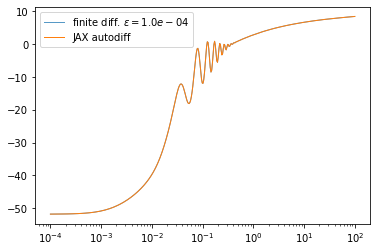

In [22]:
fig, ax = plt.subplots()
ax.semilogx(k_modes, dPkm_fd1, label=f'finite diff. $\\epsilon={epsilon:.1e}$', alpha=0.75, lw=1)
ax.semilogx(k_modes, dPk[:, 1] / power_spectra[0], label='JAX autodiff', lw=1)
# ax.set_xlabel(r'$k\; [\text{Mpc}^{1}]$')
# ax.set_ylabel(r'$\partial \log P(k)/\partial \log \Omega_m\;[1]$')
# ax.set_ylim(-2,3)
ax.legend()

In [23]:
diff_pk_batched = jax.vmap(diff_pk, in_axes=(None, 0))

In [25]:
dPk_batch = diff_pk_batched(np.logspace(-4, 2, 420), cosmo_params_samples)
dPk_batch.shape

(10000, 420, 6)

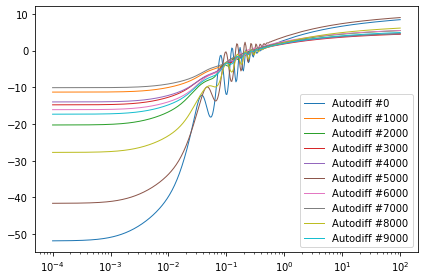

In [26]:
fig, ax = plt.subplots()

# Assume:
# dPkm.shape = (batch_size, num_k)
# Pk_in_Mpc_h.shape = (num_k,)
# k_modes.shape = (num_k,)
# Omegam_fid is a scalar

for i in range(0, len(dPk_batch), 1000):
    ax.semilogx(
        k_modes,
        dPk_batch[i, :, 1] / power_spectra[i], #power_spectra[i],
        label=f'Autodiff #{i}',
        lw=1
    )

# ax.set_ylim(-2, 6)
ax.legend()
plt.tight_layout()
plt.show()

In [18]:
# training_data['diff_power_spectra'] = dPk_batch
# training_data.keys()

dict_keys(['cosmo_params_samples', 'power_spectra', 'modes', 'cosmo_params_names', 'diff_power_spectra'])

In [19]:
# np.savez('./training_data/training_data_EH.npz', **training_data)

### Hessian computation

In [33]:
hessian_pk = jax.jacfwd(jax.jacfwd(compute_pk, argnums=1), argnums=1)
hess_Pk = hessian_pk(np.logspace(-4, 2, 420), cosmo_params_samples[0])
print(hess_Pk.shape)

(420, 6, 6)


In [41]:
hessian_pk_batched = jax.vmap(hessian_pk, in_axes=(None, 0))
hess_Pk_batch1 = hessian_pk_batched(np.logspace(-4, 2, 420), cosmo_params_samples[:5000])
hess_Pk_batch2 = hessian_pk_batched(np.logspace(-4, 2, 420), cosmo_params_samples[5000:])
hess_Pk_batch = np.concatenate((hess_Pk_batch1, hess_Pk_batch2), axis=0)
print(hess_Pk_batch1.shape, hess_Pk_batch2.shape, hess_Pk_batch.shape)

(5000, 420, 6, 6) (5000, 420, 6, 6) (10000, 420, 6, 6)


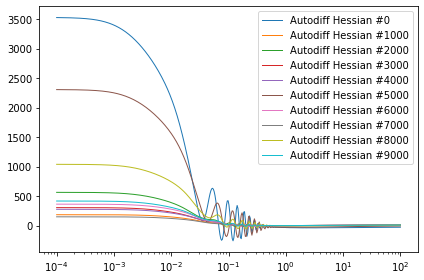

In [42]:
fig, ax = plt.subplots()

# Assume:
# dPkm.shape = (batch_size, num_k)
# Pk_in_Mpc_h.shape = (num_k,)
# k_modes.shape = (num_k,)
# Omegam_fid is a scalar

for i in range(0, len(dPk_batch), 1000):
    ax.semilogx(
        k_modes,
        hess_Pk_batch[i, :, 1, 1] / power_spectra[i], #power_spectra[i],
        label=f'Autodiff Hessian #{i}',
        lw=1
    )

# ax.set_ylim(-2, 6)
ax.legend()
plt.tight_layout()
plt.show()

In [43]:
# training_data['hess_power_spectra'] = hess_Pk_batch
# training_data.keys()

dict_keys(['cosmo_params_samples', 'power_spectra', 'modes', 'cosmo_params_names', 'diff_power_spectra', 'hess_power_spectra'])

In [44]:
# np.savez('./training_data/training_data_EH.npz', **training_data)